In [ ]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm

DATASET_DIR = Path(r"path/to/your/dataset")  # Update this path to your dataset directory
OUTPUT_CSV_PATH = DATASET_DIR / "metadata.csv"

def generate_metadata():
    if not DATASET_DIR.is_dir():
        print(f"Error: Dataset directory not found at '{DATASET_DIR}'")
        print("Please run the 'final_prepare_dataset.py' script first.")
        return

    metadata_list = []
    splits = ['train', 'validation', 'test']

    print("Scanning dataset folders to generate metadata...")

    for split in splits:
        image_dir = DATASET_DIR / split / 'images'
        mask_dir = DATASET_DIR / split / 'masks'

        if not image_dir.is_dir():
            print(f"Warning: '{split}/images' directory not found. Skipping.")
            continue

        for image_path in tqdm(list(image_dir.glob('*.*')), desc=f"Processing '{split}' set"):
            mask_path = mask_dir / image_path.name

            if mask_path.exists():
                if 'noncrack' in image_path.name:
                    image_class = 'non_crack'
                else:
                    image_class = 'crack'

                metadata_list.append({
                    'image_path': str(image_path),
                    'mask_path': str(mask_path),
                    'class': image_class,
                    'split': split
                })

    if not metadata_list:
        print("No image-mask pairs were found. Cannot create metadata file.")
        return

    df = pd.DataFrame(metadata_list)
    df.to_csv(OUTPUT_CSV_PATH, index=False)

    print(f"\nMetadata file created successfully at: '{OUTPUT_CSV_PATH}'")
    print(f"Total entries in metadata: {len(df)}")
    print("\n--- First 5 rows of metadata.csv ---")
    print(df.head())
    print("\n--- Split counts ---")
    print(df['split'].value_counts())

if __name__ == "__main__":
    generate_metadata()

In [ ]:
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

tqdm.pandas()


sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (14, 7)

print("Libraries imported successfully.")


Libraries imported successfully.


In [ ]:
METADATA_PATH = Path(r"path/to/your/directory/metadata.csv")


if not METADATA_PATH.exists():
    print(f"ERROR: Metadata file not found at '{METADATA_PATH}'")
else:
    df = pd.read_csv(METADATA_PATH)
    print("Metadata.csv loaded successfully.")
    print(f"Total records found: {len(df)}")
    display(df.head())


Metadata.csv loaded successfully.
Total records found: 27222


,image_path,mask_path,class,split
0,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,non_crack,train
1,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,non_crack,train
2,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,non_crack,train
3,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,non_crack,train
4,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,non_crack,train


In [ ]:


def analyze_crack_geometry(mask_path_str):
    """
    Analyzes a single mask image to find the properties of all cracks within it.
    
    Args:
        mask_path_str (str): The file path to the mask image.

    Returns:
        list: A list of dictionaries, where each dictionary contains the
              properties (length, width, angle) of one detected crack contour.
              Returns an empty list if no cracks are found or the file is invalid.
    """
    mask_path = Path(mask_path_str)
    if not mask_path.exists():
        return []

    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return []

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    properties = []
    for contour in contours:
        if cv2.contourArea(contour) < 10:
            continue
        rect = cv2.minAreaRect(contour)
        (w, h) = rect[1]
        width = min(w, h)
        length = max(w, h)
        angle = rect[2]
        if w < h:
            orientation = angle + 90
        else:
            orientation = angle
        properties.append({
            'length_pixels': length,
            'width_pixels': width,
            'orientation_degrees': orientation
        })
    return properties


print("Applying geometric analysis to all crack masks. This may take several minutes...")


crack_df = df[df['class'] == 'crack'].copy()
print(f"Found {len(crack_df)} 'crack' samples to analyze.")


crack_df['geometry_data'] = crack_df['mask_path'].progress_apply(analyze_crack_geometry)

print("\nAnalysis complete. Geometric properties have been extracted.")
display(crack_df.head())


Applying geometric analysis to all crack masks. This may take several minutes...
Found 13611 'crack' samples to analyze.


  0%|          | 0/13611 [00:00<?, ?it/s]


Analysis complete. Geometric properties have been extracted.


,image_path,mask_path,class,split,geometry_data
10946,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,crack,train,"[{'length_pixels': 531.2614135742188, 'width_p..."
10947,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,crack,train,"[{'length_pixels': 568.6820068359375, 'width_p..."
10948,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,crack,train,"[{'length_pixels': 511.5887451171875, 'width_p..."
10949,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,crack,train,"[{'length_pixels': 469.1004333496094, 'width_p..."
10950,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,crack,train,"[{'length_pixels': 511.04315185546875, 'width_..."


In [ ]:
crack_df_filtered = crack_df[crack_df['geometry_data'].apply(lambda x: len(x) > 0)].copy()

crack_geometries = crack_df_filtered.explode('geometry_data')

geometries_df = pd.json_normalize(crack_geometries['geometry_data'])
final_geometries_df = pd.concat([
    crack_geometries[['image_path', 'mask_path']].reset_index(drop=True),
    geometries_df
], axis=1)

print(f"Created a new DataFrame with {len(final_geometries_df)} individual crack measurements.")
display(final_geometries_df.head())


Created a new DataFrame with 35285 individual crack measurements.


,image_path,mask_path,length_pixels,width_pixels,orientation_degrees
0,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,531.261414,416.354187,85.436180
1,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,568.682007,363.238251,167.156120
2,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,511.588745,363.699951,91.949742
3,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,469.100433,400.656555,90.926536
4,C:\Users\HP\Desktop\droneaimodel\final_dataset...,C:\Users\HP\Desktop\droneaimodel\final_dataset...,511.043152,68.142090,82.234833


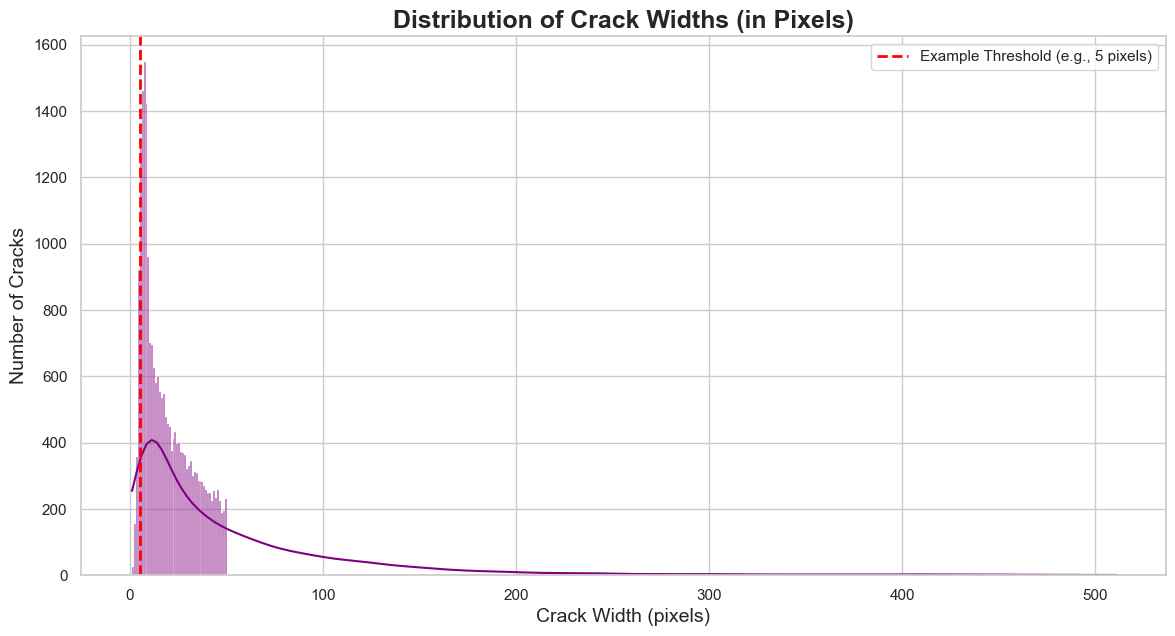

This plot is crucial. To relate this to your 3mm requirement, you need a pixel-to-mm conversion factor.
For example, if you determine that 5 pixels = 3mm in your 512x512 patches, this plot shows how many
of your annotated cracks meet that threshold.


In [7]:
plt.figure(figsize=(14, 7))
sns.histplot(final_geometries_df['width_pixels'], bins=50, kde=True, binrange=(0, 50), color='purple')
plt.title('Distribution of Crack Widths (in Pixels)', fontsize=18, weight='bold')
plt.xlabel('Crack Width (pixels)', fontsize=14)
plt.ylabel('Number of Cracks', fontsize=14)
plt.axvline(x=5, color='red', linestyle='--', linewidth=2, label='Example Threshold (e.g., 5 pixels)')
plt.legend()
plt.show()

print("This plot is crucial. To relate this to your 3mm requirement, you need a pixel-to-mm conversion factor.")
print("For example, if you determine that 5 pixels = 3mm in your 512x512 patches, this plot shows how many")
print("of your annotated cracks meet that threshold.")


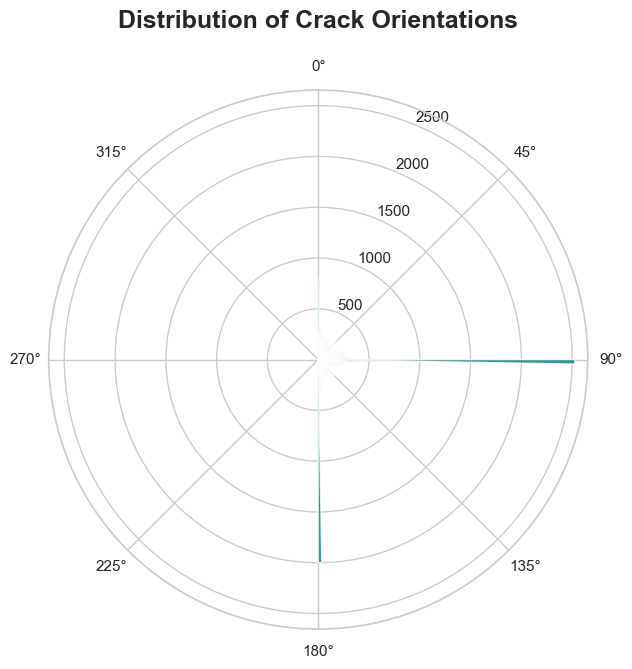

This plot shows the prevalence of crack angles. 0° is vertical, 90° is horizontal.
A uniform distribution is ideal, while strong peaks indicate a potential bias in the dataset.


In [ ]:
plt.figure(figsize=(14, 7))

orientations = final_geometries_df['orientation_degrees']

orientations_rad = np.deg2rad(orientations)

ax = plt.subplot(111, polar=True)
ax.hist(orientations_rad, bins=180, color='teal', alpha=0.8) 
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1) 
ax.set_title('Distribution of Crack Orientations', fontsize=18, weight='bold', y=1.1)
plt.show()

print("This plot shows the prevalence of crack angles. 0° is vertical, 90° is horizontal.")
print("A uniform distribution is ideal, while strong peaks indicate a potential bias in the dataset.")


In [10]:

OUTPUT_GEOMETRY_CSV = Path("./crack_geometriess.csv")
final_geometries_df.to_csv(OUTPUT_GEOMETRY_CSV, index=False)

print(f"Successfully saved the detailed crack geometry data to: '{OUTPUT_GEOMETRY_CSV}'")


Successfully saved the detailed crack geometry data to: 'crack_geometriess.csv'


--- Analyzing Correlation Between Geometric Features ---


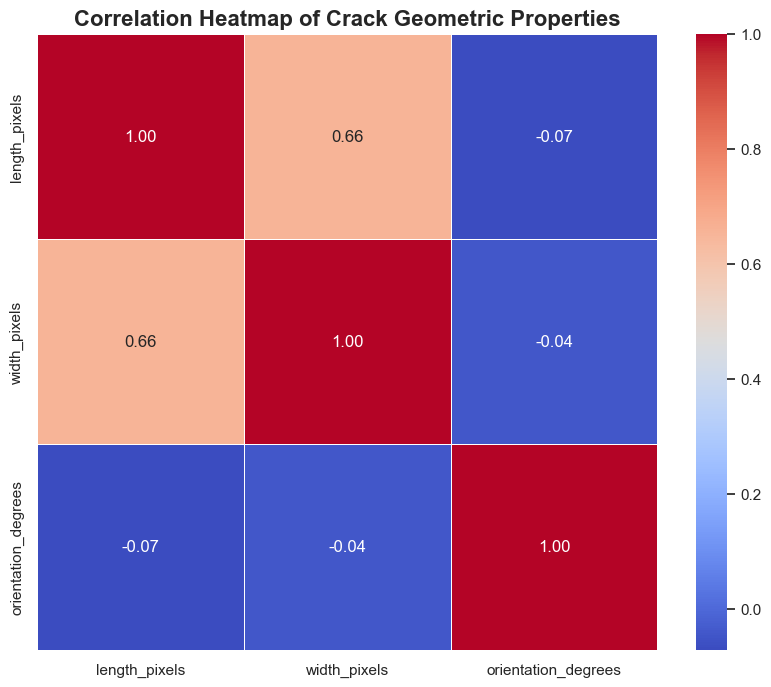


This heatmap shows the correlation between the calculated features:
- A value close to 1.0 (red) means a strong positive correlation (e.g., as length increases, width also increases).
- A value close to -1.0 (blue) means a strong negative correlation.
- A value close to 0.0 (white) means there is little to no linear relationship between the features.


In [ ]:
print("--- Analyzing Correlation Between Geometric Features ---")


numerical_features = final_geometries_df[['length_pixels', 'width_pixels', 'orientation_degrees']]


correlation_matrix = numerical_features.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,          
    linewidths=.5
)
plt.title('Correlation Heatmap of Crack Geometric Properties', fontsize=16, weight='bold')
plt.show()

print("\nThis heatmap shows the correlation between the calculated features:")
print("- A value close to 1.0 (red) means a strong positive correlation (e.g., as length increases, width also increases).")
print("- A value close to -1.0 (blue) means a strong negative correlation.")
print("- A value close to 0.0 (white) means there is little to no linear relationship between the features.")
